(ensemble_prop)=

# Ensemble propagations

Starting with version 0.17.0, heyoka.py offers support for
*ensemble propagations*. In ensemble mode, multiple distinct
instances of the same ODE system are integrated in parallel,
typically using different sets of initial conditions and/or
[runtime parameters](<./Non-autonomous systems.ipynb>).
Monte Carlo simulations and parameter
searches are two typical examples of tasks in which ensemble mode
is particularly useful.


The ensemble mode API mirrors the time-limited propagation
functions available in the
[adaptive integrator class](<./The adaptive integrator.ipynb>). Specifically,
three functions are available:

* ``ensemble_propagate_until()``, for ensemble propagations
  up to a specified epoch,
* ``ensemble_propagate_for()``, for ensemble propagations
  for a time interval,
* ``ensemble_propagate_grid()``, for ensemble propagations
  over a time grid.

In this tutorial, we will be focusing on the ``ensemble_propagate_until()``
function, but adapting the code to the other two functions
should be straightforward.

At this time, ensemble propagations can use multiple threads of executions or multiple processes
to achieve parallelisation. In the future, additional parallelisation
modes (e.g., distributed) may be added.

## A simple example

As usual, for this illustrative tutorial we will be using the ODEs of the simple pendulum.
Thus, let us begin with the definition of the symbolic variables and of an integrator object:

In [1]:
import heyoka as hy

x, v = hy.make_vars("x", "v")

# Create the integrator object.
ta = hy.taylor_adaptive(
                        # Definition of the ODE system:
                        # x' = v
                        # v' = -9.8 * sin(x)
                        sys = [(x, v),
                         (v, -9.8 * hy.sin(x))],
                        # Initial conditions for x and v.
                        state = [0. ,0.])

Note how, differently from the other tutorials, here we have set the initial conditions
to zeroes. This is because, in ensemble mode, we will never use directly the ``ta`` object to perform
a numerical integration. Rather, ``ta`` acts as a *template* from which other integrator
objects will be constructed, and thus its initial conditions are inconsequential.

The ``ensemble_propagate_until()`` function takes in input at least 4 arguments:

* the template integrator ``ta``,
* the final epoch ``t`` for the propagations (this argument would be a time interval ``delta_t``
  for ``ensemble_propagate_for()`` and a time grid for ``ensemble_propagate_grid()``),
* the number of iterations ``n_iter`` in the ensemble,
* a function object ``gen``, known as the *generator*.

The generator is a callable that takes two input arguments:

* a *deep copy* of the template integrator ``ta``, and
* an iteration index ``idx`` in the ``[0, n_iter)`` range.

``gen`` is then expected to modify the copy of ``ta`` (e.g., by setting its initial conditions to specific
values) and return it.

The ``ensemble_propagate_until()`` function iterates over
the ``[0, n_iter)`` range. At each iteration, the generator ``gen`` is invoked,
with the template integrator as the first argument and the current iteration number
as the second argument. The ``propagate_until()`` member
function is then called on the integrator returned by ``gen``, and the result of the propagation
is appended to a list of results which is finally returned by
``ensemble_propagate_until()`` once all the propagations have finished.

Let us see a concrete example of ``ensemble_propagate_until()`` in action. First, we
begin by creating 10 sets of different initial conditions to be used in the ensemble
propagations:

In [2]:
# Create 10 sets of random initial conditions,
# one for each element of the ensemble.
import numpy as np

ensemble_ics = np.array([0.05, 0.025]) + np.random.uniform(-1e-2, 1e-2, (10, 2))

Next, we define a generator that will pick a set of initial conditions from ``ensemble_ics``,
depending on the iteration index:

In [3]:
# The generator.
def gen(ta_copy, idx):
    # Reset the time to zero.
    ta.time = 0.
    
    # Fetch initial conditions from ensemble_ics.
    ta_copy.state[:] = ensemble_ics[idx]

    return ta_copy

We are now ready to invoke the ``ensemble_propagate_until()`` function:

In [4]:
# Run the ensemble propagation up to t = 20.
ret = hy.ensemble_propagate_until(ta, 20., 10, gen)

The value returned by ``ensemble_propagate_until()`` is a list of tuples constructed by concatenating the integrator
object used for each integration and the tuple returned by each ``propagate_until()`` invocation. This way, at the end
of an ensemble propagation it is possible to inspect both the state of each integrator object and the output of
each invocation of ``propagate_until()`` (including, e.g., the [continuous output](<./Dense output.ipynb>), if
requested).

For instance, let us take a look at the first value in ret:

In [5]:
ret[0]

(Tolerance               : 2.2204460492503131e-16
 High accuracy           : false
 Compact mode            : false
 Taylor order            : 20
 Dimension               : 2
 Time                    : 20.000000000000000
 State                   : [0.053129579044398502, 0.061908760550694837],
 <taylor_outcome.time_limit: -4294967299>,
 0.1973814707168774,
 0.22082912150625117,
 98,
 None)

The first element of the tuple is the integrator object that was used in the invocation of ``propagate_until()``. The remaining elements of the tuple are the output of the ``propagate_until()`` invocation (i.e., integration outcome, min/max timestep, etc., as detailed in the [adatpive integrator tutorial](<./The adaptive integrator.ipynb>)).

The ``ensemble_propagate_until()`` function can be invoked with additional optional keyword arguments, beside the mandatory initial 4:

* the ``algorithm`` keyword argument is a string that specifies the parallelisation algorithm that will be used by ``ensemble_propagate_until()``. The supported values are currently ``"thread"`` (the default) and ``"process"`` (see below for a discussion of the pros and cons of each method);
* the ``max_workers`` keyword argument is an integer that specifies how many workers are spawned during parallelisation. Defaults to ``None``, see the [Python docs](https://docs.python.org/3/library/concurrent.futures.html) for a detailed explanation;
* the ``chunksize`` keyword argument is an integer that specifies the size of the tasks that are submitted to the parallel workers. Defaults to 1, see the [Python docs](https://docs.python.org/3/library/concurrent.futures.html) for a detailed explanation.
  This keyword argument can be specified only when using the ``process`` parallelisation method.

Any other keyword argument passed to ``ensemble_propagate_until()`` will be forwarded to the ``propagate_until()`` invocations.

Let us see a comprehensive example with multiple keyword arguments:

In [6]:
ret = hy.ensemble_propagate_until(ta, 20., 10, gen,
                                  # Use no more than 8 worker threads.
                                  max_workers = 8,
                                  # Request continuous output.
                                  c_output = True
                                 )

Let us now use the continuous output to plot the evolution of the $x$ coordinate over time for each element of the ensemble:

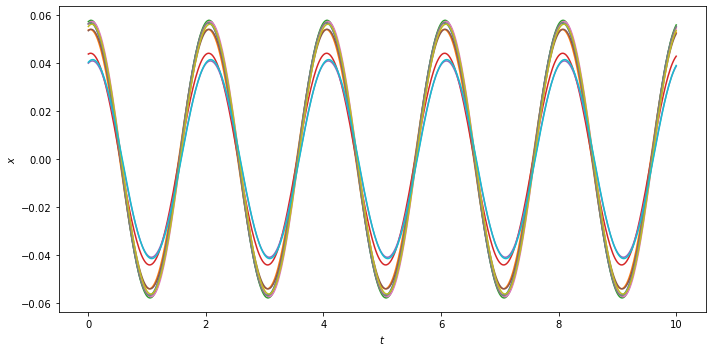

In [7]:
from matplotlib.pylab import plt

fig = plt.figure(figsize=(10, 5))

# Create a time range.
t_rng = np.linspace(0, 10., 500)

for tup in ret:
    # Fetch the continuous output function object.
    c_out = tup[5]

    plt.plot(t_rng, c_out(t_rng)[:,0])

plt.xlabel("$t$")
plt.ylabel("$x$")
plt.tight_layout();

## Choosing between threads and processes

Ensemble propagations default to using multiple threads of execution for parallelisation. Multithreading usually performs better than multiprocessing, however there are at least two big caveats to keep in mind when using multithreading:

* first, it is the user's responsibility to ensure that the user-provided function objects such as the generator and
  the callbacks (if present) are safe for use in a multithreaded context. In particular, the following actions will be performed
  concurrently by separate threads of execution:

  * invocation of the generator's call operator and of the call operator
    of the callback that can (optionally) be passed to the ``propagate_*()``
    functions. In other words, both the generator and the ``propagate_*()``
    callback are shared among several threads of execution and used
    concurrently;
  * deep copy of the events callbacks and invocation of the
    call operator on the copies. That is, each thread of execution
    gets its own copy of the event callbacks thanks to the creation
    of a new integrator object via the generator.
  
  For instance, an event callback which performs write operations
  on a global variable without using some form of synchronisation
  will result in unpredictable behaviour when used in an ensemble propagation.
  Similarly, a ``propagate_*()`` callback that
  performs write operations into its own data member(s) without
  synchronisation will also result in a data race, because the
  ``propagate_*()`` callback is shared among several threads;

* second, due to the [global interpreter lock (GIL)](https://docs.python.org/3/glossary.html#term-global-interpreter-lock), Python is typically not able to execute code concurrently from multiple threads.
  Thus, if a considerable portion of the integration time if spent executing user-defined callbacks, ensemble simulations will exhibit poor parallel speedup.

As an alternative, it is possible to use multiple *processes* (instead of threads) when performing ensemble propagations by passing the keyword argument ``algorithm="process"``. Processes have a higher initial creation overhead, but they also feature two important advantages:

* there are no safety concerns regarding data sharing, as each process gets its own copy of all the data necessary to perform an integration;
* the GIL performance issues are avoided because there are multiple Python interpreters running in parallel (rather than multiple threads sharing exclusive access to a single interpreter), and thus ensemble propagations with event detection may parallelise more efficiently when using multiprocessing.

When employing multiprocessing, users should be aware that the ``chunksize`` keyword argument can have a big influence on performance. Please see the explanation in the [Python docs](https://docs.python.org/3/library/concurrent.futures.html) for more detailed information.